In [1]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb
nltk.download('wordnet')

2024-04-18 06:42:50.219946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 06:42:50.220072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 06:42:50.364251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [2]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes-deberta-large/*/*'
EVAL_BATCH_SIZE = 1

In [3]:
models = glob(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [4]:
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)

In [5]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4


In [6]:
df_test[['essay_id', 'score']].to_csv('submission1.csv', index=False)

# Data Loading
Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data

In [7]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


# **Preprocessing**

In [8]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

### Paragraph Features

In [9]:
def Paragraph_Preprocess(tmp):
    
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']

def Paragraph_Eng(train_tmp):
    aggs = [
        
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


### Sentence Features

In [10]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


### Word Features

In [11]:
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)
    return tmp

def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


### 5.Tf-idf features

In [12]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  19696


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_19617,tfid_19618,tfid_19619,tfid_19620,tfid_19621,tfid_19622,tfid_19623,tfid_19624,tfid_19625,tfid_19626
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### CountVectorizer Features

In [13]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

# **Model training**

In [14]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes-deberta-large/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape

(17307, 6) (17307, 21868)
Features Number:  21872


(17307, 21874)

In [15]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092


In [16]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(int).values

In [17]:
len(feature_names)

21872

# **Let's use cross-validation**

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.823493	valid's QWK: 0.829403
[50]	train's QWK: 0.836719	valid's QWK: 0.833884
[75]	train's QWK: 0.843479	valid's QWK: 0.833986
[100]	train's QWK: 0.848475	valid's QWK: 0.832233
[125]	train's QWK: 0.853581	valid's QWK: 0.831458
Early stopping, best iteration is:
[62]	train's QWK: 0.840306	valid's QWK: 0.836977
Evaluated only: QWK


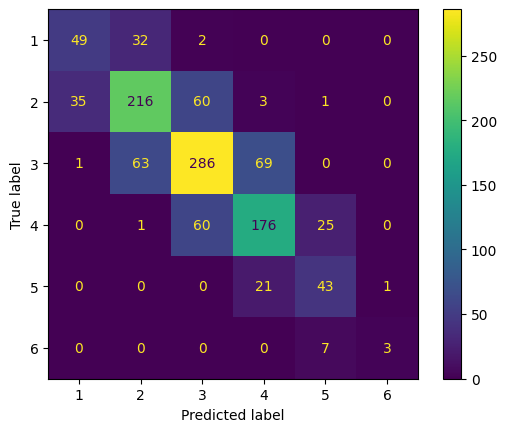

F1 score across fold: 0.6697272308774708
Cohen kappa score across fold: 0.8369774571735914
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.820638	valid's QWK: 0.825272
[50]	train's QWK: 0.835814	valid's QWK: 0.836123
[75]	train's QWK: 0.843752	valid's QWK: 0.837385
[100]	train's QWK: 0.848971	valid's QWK: 0.833378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.853354	valid's QWK: 0.834889
Early stopping, best iteration is:
[61]	train's QWK: 0.83928	valid's QWK: 0.838671
Evaluated only: QWK


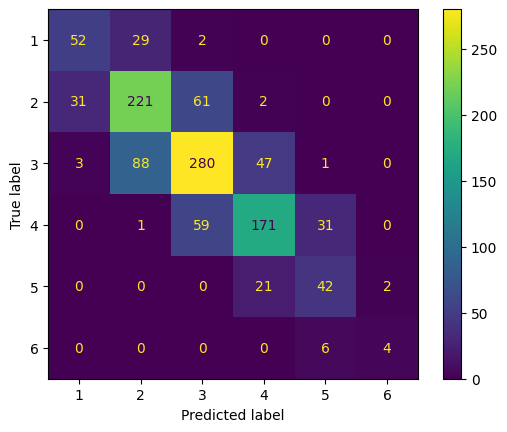

F1 score across fold: 0.6677287489682007
Cohen kappa score across fold: 0.8386712300530422
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.820981	valid's QWK: 0.819286
[50]	train's QWK: 0.838047	valid's QWK: 0.831196
[75]	train's QWK: 0.843298	valid's QWK: 0.832174
[100]	train's QWK: 0.847762	valid's QWK: 0.834489
[125]	train's QWK: 0.85198	valid's QWK: 0.835384
[150]	train's QWK: 0.855556	valid's QWK: 0.836938
[175]	train's QWK: 0.859588	valid's QWK: 0.836582
[200]	train's QWK: 0.863125	valid's QWK: 0.836775
Early stopping, best iteration is:
[130]	train's QWK: 0.85313	valid's QWK: 0.838303
Evaluated only: QWK


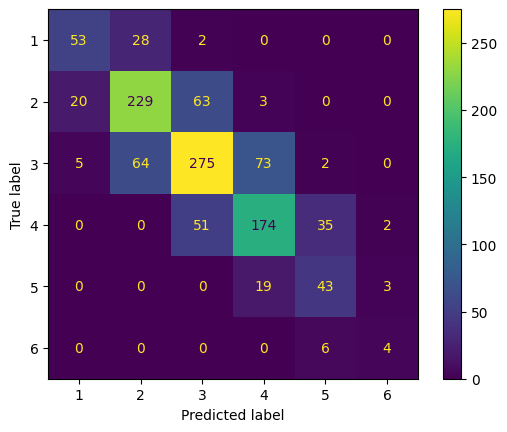

F1 score across fold: 0.6749812536990111
Cohen kappa score across fold: 0.8383028591617944
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.824309	valid's QWK: 0.819644
[50]	train's QWK: 0.836635	valid's QWK: 0.824266
[75]	train's QWK: 0.8415	valid's QWK: 0.830489
[100]	train's QWK: 0.847402	valid's QWK: 0.832235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.851695	valid's QWK: 0.835654
[150]	train's QWK: 0.855954	valid's QWK: 0.835719
[175]	train's QWK: 0.859766	valid's QWK: 0.834468
[200]	train's QWK: 0.864117	valid's QWK: 0.83358
[225]	train's QWK: 0.867996	valid's QWK: 0.835152
Early stopping, best iteration is:
[162]	train's QWK: 0.857602	valid's QWK: 0.837523
Evaluated only: QWK


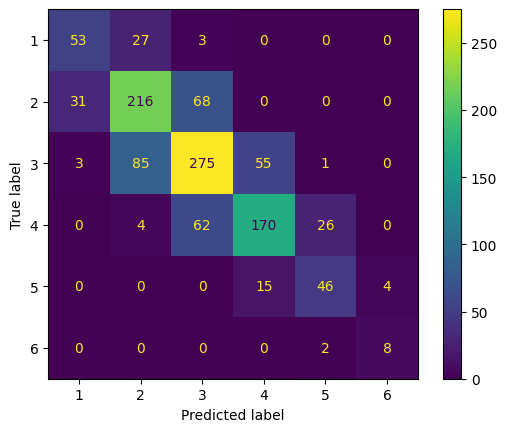

F1 score across fold: 0.665660769152961
Cohen kappa score across fold: 0.8375225725631881
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.824843	valid's QWK: 0.814734
[50]	train's QWK: 0.837461	valid's QWK: 0.824633
[75]	train's QWK: 0.84373	valid's QWK: 0.829865
[100]	train's QWK: 0.848566	valid's QWK: 0.828493
[125]	train's QWK: 0.853115	valid's QWK: 0.82715
[150]	train's QWK: 0.857392	valid's QWK: 0.827722
Early stopping, best iteration is:
[75]	train's QWK: 0.84373	valid's QWK: 0.829865
Evaluated only: QWK


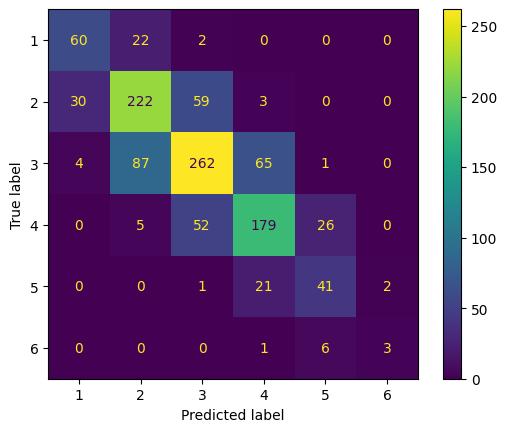

F1 score across fold: 0.6640139181724128
Cohen kappa score across fold: 0.8298654681954535
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.822958	valid's QWK: 0.826808
[50]	train's QWK: 0.835218	valid's QWK: 0.833545
[75]	train's QWK: 0.841848	valid's QWK: 0.835868
[100]	train's QWK: 0.84687	valid's QWK: 0.836992
[125]	train's QWK: 0.851498	valid's QWK: 0.834727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.855952	valid's QWK: 0.835731
Early stopping, best iteration is:
[97]	train's QWK: 0.846243	valid's QWK: 0.838053
Evaluated only: QWK


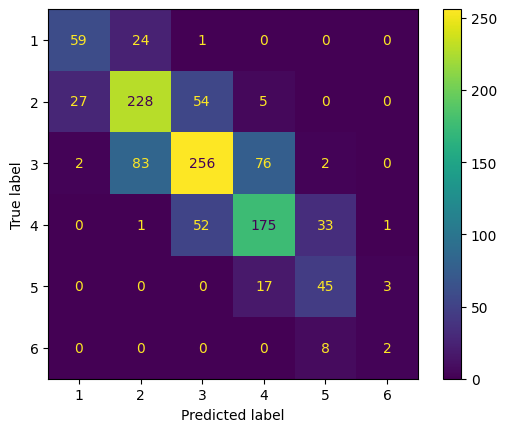

F1 score across fold: 0.6623748942762226
Cohen kappa score across fold: 0.8380533246864914
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.823244	valid's QWK: 0.798719
[50]	train's QWK: 0.837018	valid's QWK: 0.815201
[75]	train's QWK: 0.844168	valid's QWK: 0.819129
[100]	train's QWK: 0.848211	valid's QWK: 0.820055
[125]	train's QWK: 0.852158	valid's QWK: 0.824348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.856627	valid's QWK: 0.823823
[175]	train's QWK: 0.859855	valid's QWK: 0.825306
[200]	train's QWK: 0.863664	valid's QWK: 0.823462
[225]	train's QWK: 0.866893	valid's QWK: 0.824648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[172]	train's QWK: 0.859026	valid's QWK: 0.825851
Evaluated only: QWK


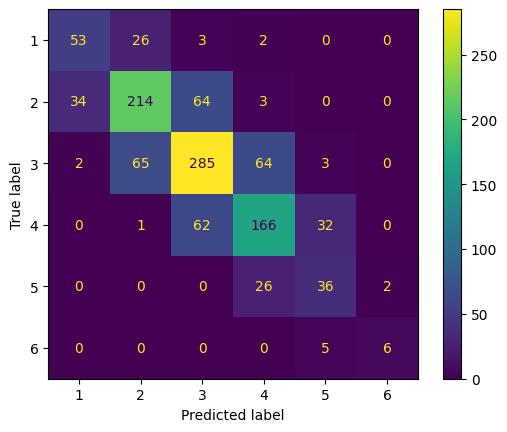

F1 score across fold: 0.659568453879459
Cohen kappa score across fold: 0.8258513989504066
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.819402	valid's QWK: 0.81887
[50]	train's QWK: 0.83472	valid's QWK: 0.830426
[75]	train's QWK: 0.841217	valid's QWK: 0.83013
[100]	train's QWK: 0.847052	valid's QWK: 0.828826
[125]	train's QWK: 0.851443	valid's QWK: 0.830846
Early stopping, best iteration is:
[61]	train's QWK: 0.837984	valid's QWK: 0.8325
Evaluated only: QWK


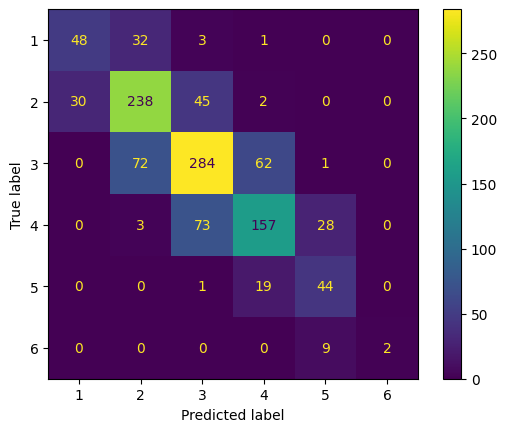

F1 score across fold: 0.6678073530370864
Cohen kappa score across fold: 0.8324995132874264
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.821382	valid's QWK: 0.805596
[50]	train's QWK: 0.83563	valid's QWK: 0.820363
[75]	train's QWK: 0.843698	valid's QWK: 0.826252
[100]	train's QWK: 0.848641	valid's QWK: 0.827843
[125]	train's QWK: 0.852974	valid's QWK: 0.826535
[150]	train's QWK: 0.857196	valid's QWK: 0.827541
[175]	train's QWK: 0.861095	valid's QWK: 0.828087
[200]	train's QWK: 0.86545	valid's QWK: 0.827243
[225]	train's QWK: 0.869104	valid's QWK: 0.828096
[250]	train's QWK: 0.872811	valid's QWK: 0.829949
[275]	train's QWK: 0.876775	valid's QWK: 0.830136
[300]	train's QWK: 0.87949	valid's QWK: 0.830487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	train's QWK: 0.882936	valid's QWK: 0.830025
[350]	train's QWK: 0.885389	valid's QWK: 0.830566
[375]	train's QW

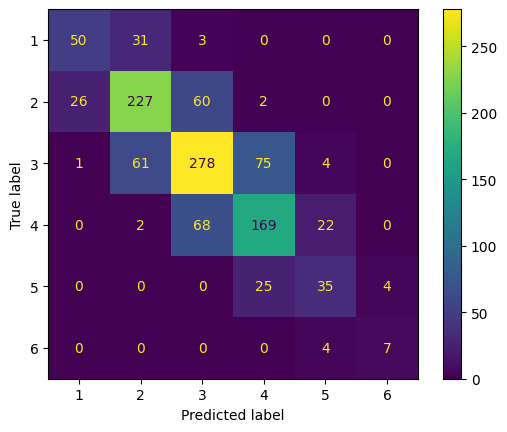

F1 score across fold: 0.663727800670226
Cohen kappa score across fold: 0.8318571602356286
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.820932	valid's QWK: 0.817027
[50]	train's QWK: 0.835791	valid's QWK: 0.829711
[75]	train's QWK: 0.842885	valid's QWK: 0.830997
[100]	train's QWK: 0.848021	valid's QWK: 0.830719
[125]	train's QWK: 0.852692	valid's QWK: 0.8313
[150]	train's QWK: 0.857259	valid's QWK: 0.832643
[175]	train's QWK: 0.861069	valid's QWK: 0.833158
[200]	train's QWK: 0.864594	valid's QWK: 0.834516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	train's QWK: 0.868587	valid's QWK: 0.834456
[250]	train's QWK: 0.872018	valid's QWK: 0.835616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	train's QWK: 0.87462	valid's QWK: 0.83472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK

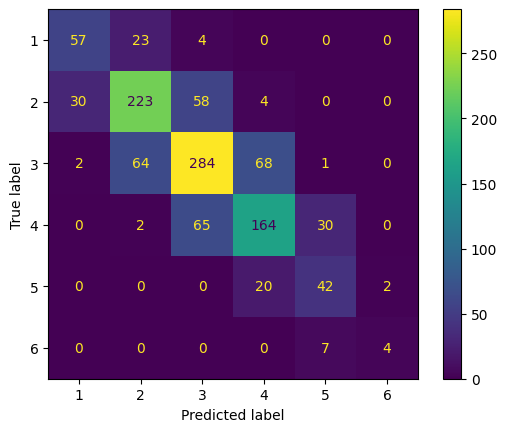

F1 score across fold: 0.6709296478527977
Cohen kappa score across fold: 0.8362692665325286
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.821808	valid's QWK: 0.822759
[50]	train's QWK: 0.835389	valid's QWK: 0.831353
[75]	train's QWK: 0.842968	valid's QWK: 0.833466
[100]	train's QWK: 0.848308	valid's QWK: 0.837204
[125]	train's QWK: 0.853368	valid's QWK: 0.836069
[150]	train's QWK: 0.857644	valid's QWK: 0.838801
[175]	train's QWK: 0.861436	valid's QWK: 0.837095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.864335	valid's QWK: 0.838618
[225]	train's QWK: 0.867636	valid's QWK: 0.838321
Early stopping, best iteration is:
[156]	train's QWK: 0.858533	valid's QWK: 0.839442
Evaluated only: QWK


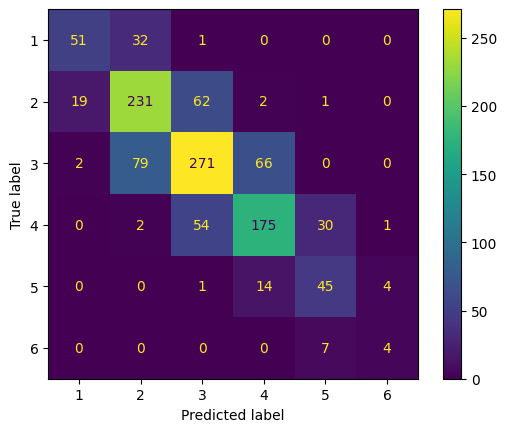

F1 score across fold: 0.6731072968385928
Cohen kappa score across fold: 0.8394418516692445
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.823001	valid's QWK: 0.824544
[50]	train's QWK: 0.835157	valid's QWK: 0.83493
[75]	train's QWK: 0.841399	valid's QWK: 0.83339
[100]	train's QWK: 0.846905	valid's QWK: 0.835278
[125]	train's QWK: 0.852428	valid's QWK: 0.833815
Early stopping, best iteration is:
[70]	train's QWK: 0.83983	valid's QWK: 0.836267
Evaluated only: QWK


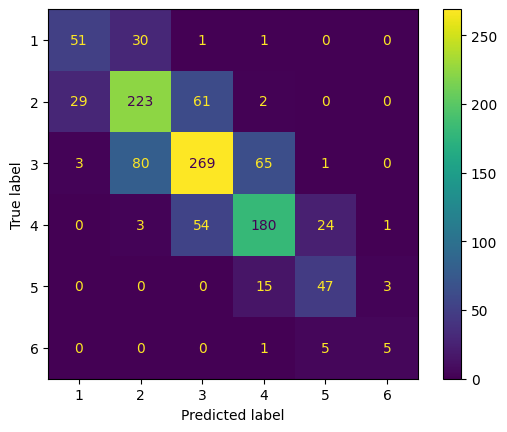

F1 score across fold: 0.6713214943684124
Cohen kappa score across fold: 0.8362665958256102
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.821399	valid's QWK: 0.81091
[50]	train's QWK: 0.83617	valid's QWK: 0.822593
[75]	train's QWK: 0.843727	valid's QWK: 0.82874
[100]	train's QWK: 0.849749	valid's QWK: 0.826709
[125]	train's QWK: 0.853888	valid's QWK: 0.830086
[150]	train's QWK: 0.858617	valid's QWK: 0.82856
[175]	train's QWK: 0.863402	valid's QWK: 0.829702
[200]	train's QWK: 0.866881	valid's QWK: 0.829569
[225]	train's QWK: 0.870365	valid's QWK: 0.831075
[250]	train's QWK: 0.873468	valid's QWK: 0.827007
[275]	train's QWK: 0.8767	valid's QWK: 0.826164
[300]	train's QWK: 0.880169	valid's QWK: 0.826963
Early stopping, best iteration is:
[225]	train's QWK: 0.870365	valid's QWK: 0.831075
Evaluated only: QWK


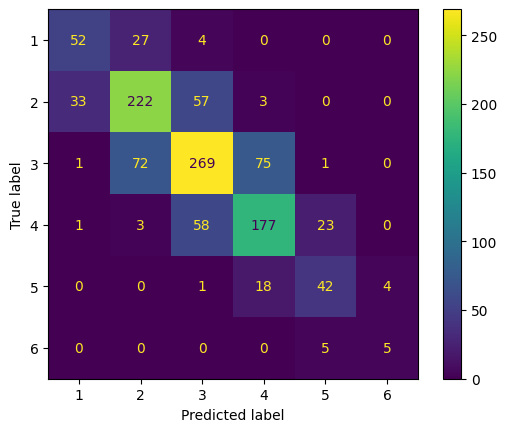

F1 score across fold: 0.6652969133333386
Cohen kappa score across fold: 0.8310750752254564
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.822157	valid's QWK: 0.822295
[50]	train's QWK: 0.836573	valid's QWK: 0.833901
[75]	train's QWK: 0.843361	valid's QWK: 0.837201
[100]	train's QWK: 0.847117	valid's QWK: 0.837581
[125]	train's QWK: 0.852197	valid's QWK: 0.839232
[150]	train's QWK: 0.85617	valid's QWK: 0.840316
[175]	train's QWK: 0.859178	valid's QWK: 0.839081
[200]	train's QWK: 0.862738	valid's QWK: 0.837317
Early stopping, best iteration is:
[147]	train's QWK: 0.855203	valid's QWK: 0.841228
Evaluated only: QWK


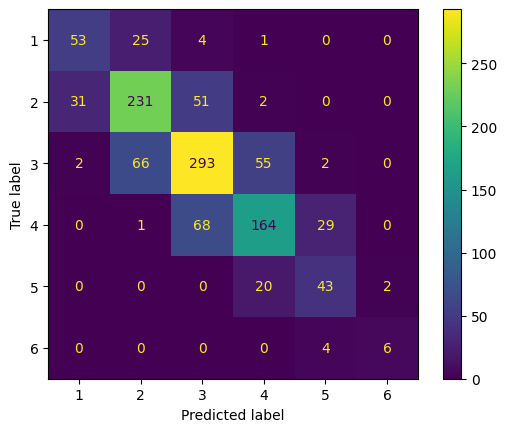

F1 score across fold: 0.6852825412217656
Cohen kappa score across fold: 0.841227987055881
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.824527	valid's QWK: 0.835338
[50]	train's QWK: 0.838244	valid's QWK: 0.840051
[75]	train's QWK: 0.844475	valid's QWK: 0.84007
[100]	train's QWK: 0.849701	valid's QWK: 0.840713
[125]	train's QWK: 0.85394	valid's QWK: 0.839031
[150]	train's QWK: 0.857402	valid's QWK: 0.83814
[175]	train's QWK: 0.861285	valid's QWK: 0.837916
Early stopping, best iteration is:
[103]	train's QWK: 0.8505	valid's QWK: 0.840783
Evaluated only: QWK


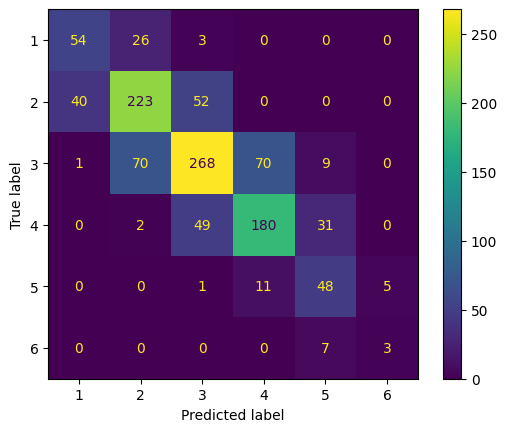

F1 score across fold: 0.6740501317939116
Cohen kappa score across fold: 0.84078316390602
Mean F1 score across 15 folds: 0.669038563209458
Mean Cohen kappa score across 15 folds: 0.8356443283014507


In [18]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

i=1
for train_index, test_index in skf.split(X, y_split):
   
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [19]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [20]:
with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# **Inference**

In [21]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  21872


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_2166,tfid_cnt_2167,tfid_cnt_2168,tfid_cnt_2169,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0.021534,0.379467,0.529225,0.066918,0.002071,0.000785
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,0.001421,0.071248,0.839511,0.086768,0.000765,0.000288
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0.001564,0.001929,0.033057,0.516632,0.433214,0.013603


In [22]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_names])+ a
    probabilities.append(proba)

predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

print(predictions)

[2. 3. 4.]


In [23]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
